In [117]:
# Data processing
import numpy as np
import pandas as pd
import xarray as xr
import iris
import iris.pandas
import warnings
warnings.filterwarnings('ignore', module='iris')
from pathlib import Path
import dateutil.parser
from datetime import datetime, timedelta
## Scientific parameters
M_air = 28.97 # molar mass of dry air [g mol-1]
# Coefficients to convert mass mixing ratio to volume mixing ratio
coeff_c2h6 = (M_air/30.0690)*1e12
coeff_c3h8 = (M_air/44.0956)*1e12
coeff_nc4h10 = (M_air/58.1222)*1e12
coeff_ic4h10 = (M_air/58.1222)*1e12
coeff_nc5h12 = (M_air/72.1488)*1e12
coeff_ic5h12 = (M_air/72.1488)*1e12
coeff_meono2 = (M_air/77.0394)*1e12
coeff_sbuono2 = (M_air/119.1192)*1e12
coeff_n2peono2 = (M_air/133.1457)*1e12
coeff_n3peono2 = (M_air/133.1457)*1e12
coeff_ipeono2 = (M_air/133.1457)*1e12
# Visualization
import cartopy.util
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from matplotlib.dates import DateFormatter
from matplotlib.ticker import FuncFormatter
# Plotting parameters
plt.rcParams['mathtext.default'] = 'regular'
def m2km(x, pos):
    '''Convert meters to kilometers when plotting axis labels'''
    return int(x*1e-3) #'{:1.1f}'.format(x*1e-3)
savefig = False
# Species names
str_c2h6 = '$C_2H_6$'; str_c3h8 = '$C_3H_8$'
str_nc4h10 = '$nC_4H_{10}$'; str_ic4h10 = '$iC_4H_{10}$'
str_nc5h12 = '$nC_5H_{12}$'; str_ic5h12 = '$iC_5H_{12}$'
str_meono2 = '$MeONO_2$'; str_sbuono2 = '2-$BuONO_2$'
str_n2peono2 = '2-$PenONO_2$'; str_n3peono2 = '3-$PenONO_2$'; str_ipeono2 = '3-Methyl-2-$BuONO_2$'

#### Read data

In [2]:
path_to_atom = Path('../../../../../../obs/ATom/nc/data')
# Select flights
fname_atom_flight = 'MER-WAS_DC8_201701*.nc'
# Read ATom data
atom_dsinf = xr.open_mfdataset(sorted(path_to_atom.glob(fname_atom_flight)), decode_times=True)
atom_dsmms = xr.open_mfdataset(sorted(path_to_atom.glob(fname_atom_flight)), group='MMS', decode_cf=True)
atom_dswas = xr.open_mfdataset(sorted(path_to_atom.glob(fname_atom_flight)), group='WAS', decode_cf=True)

In [121]:
# Choose UKCA run
ukca_run_name = 'az166a'
ukca_run_yrmn = 'pm2017jan'
path_to_ukca = Path('../../../../data') / ukca_run_name
fname_ukca_run = f'{ukca_run_name}.{ukca_run_yrmn}.pp'
# Read UKCA data
cb_c2h6 = iris.load_cube(str(path_to_ukca / fname_ukca_run), 'mass_fraction_of_ethane_in_air')*coeff_c2h6
cb_c3h8 = iris.load_cube(str(path_to_ukca / fname_ukca_run), 'mass_fraction_of_propane_in_air')*coeff_c3h8
cb_nc4h10 = iris.load_cube(str(path_to_ukca / fname_ukca_run), iris.AttributeConstraint(STASH='m01s34i173'))*coeff_nc4h10
cb_ic4h10 = iris.load_cube(str(path_to_ukca / fname_ukca_run), iris.AttributeConstraint(STASH='m01s34i174'))*coeff_ic4h10
cb_nc5h12 = iris.load_cube(str(path_to_ukca / fname_ukca_run), iris.AttributeConstraint(STASH='m01s34i175'))*coeff_nc5h12
cb_ic5h12 = iris.load_cube(str(path_to_ukca / fname_ukca_run), iris.AttributeConstraint(STASH='m01s34i176'))*coeff_ic5h12
cb_meono2 = iris.load_cube(str(path_to_ukca / fname_ukca_run), 'mass_fraction_of_methyl_nitrate_in_air')*coeff_meono2
cb_sbuono2 = iris.load_cube(str(path_to_ukca / fname_ukca_run), iris.AttributeConstraint(STASH='m01s34i188'))*coeff_sbuono2
cb_n2peono2 = iris.load_cube(str(path_to_ukca / fname_ukca_run), iris.AttributeConstraint(STASH='m01s34i189'))*coeff_n2peono2
cb_n3peono2 = iris.load_cube(str(path_to_ukca / fname_ukca_run), iris.AttributeConstraint(STASH='m01s34i190'))*coeff_n3peono2
cb_ipeono2 = iris.load_cube(str(path_to_ukca / fname_ukca_run), iris.AttributeConstraint(STASH='m01s34i191'))*coeff_ipeono2
# Load UKCA geospatial coordinates
ukca_lats = iris.load_cube(str(Path('../../../../data') / 'ukca_coords_n96e_marcus_180705.nc'), 'mass_fraction_of_ozone_in_air').coord('latitude')
ukca_lons = iris.load_cube(str(Path('../../../../data') / 'ukca_coords_n96e_marcus_180705.nc'), 'mass_fraction_of_ozone_in_air').coord('longitude')
ukca_alts = iris.load_cube(str(Path('../../../../data') / 'ukca_coords_n96e_marcus_180705.nc'), 'mass_fraction_of_ozone_in_air').coord('altitude')

In [ ]:
# Path to figures
path_to_figs = Path('../../../../../../results') / ukca_run_name / compared_common_id
path_to_figs.mkdir(exist_ok=True) # create a new folder if it doesn't exist
print(compared_common_id)

In [6]:
grid_lons, grid_lats = np.meshgrid(ukca_lons.points, ukca_lats.points)
sample_lats = atom_dsmms.G_LAT.data 
sample_lons = atom_dsmms.G_LONG.data+360
sample_alts = atom_dsmms.G_ALT.data

In [4]:
# Convert ATom C2H6, C2H4, C2H2, C3H8, C3H6 to pptvC to match UKCA lumped species, namely C2H6=C2H6+C2H4+C2H2, C3H8=C3H8+C3H6
atom_dswas_c2h6 = atom_dswas['Ethane_WAS']*2 + atom_dswas['Ethene_WAS']*2 + atom_dswas['Ethyne_WAS']*2
atom_dswas_c3h8 = atom_dswas['Propane_WAS']*3 + atom_dswas['Propene_WAS']*3
# Convert xarray dataset with observational data to pandas dataframe
atom_c2h6 = atom_dswas_c2h6.to_dataframe(name='Lumped_C2H6_C2H4_C2H2')
atom_c3h8 = atom_dswas_c3h8.to_dataframe(name='Lumped_C3H8_C3H6')
atom_nc4h10 = atom_dswas['n-Butane_WAS'].to_dataframe()
atom_ic4h10 = atom_dswas['i-Butane_WAS'].to_dataframe()
atom_nc5h12 = atom_dswas['n-Pentane_WAS'].to_dataframe()
atom_ic5h12 = atom_dswas['i-Pentane_WAS'].to_dataframe()
atom_meono2 = atom_dswas['MeONO2_WAS'].to_dataframe()
atom_sbuono2 = atom_dswas['2-BuONO2_WAS'].to_dataframe()
atom_n2peono2 = atom_dswas['2-PenONO2_WAS'].to_dataframe()
atom_n3peono2 = atom_dswas['3-PenONO2_WAS'].to_dataframe()
atom_ipeono2 = atom_dswas['3-Methyl-2-BuONO2_WAS'].to_dataframe()

In [7]:
lons_meono2_notnan = np.where(atom_meono2['MeONO2_WAS'].isna()==False, sample_lons, atom_meono2['MeONO2_WAS'])
lats_meono2_notnan = np.where(atom_meono2['MeONO2_WAS'].isna()==False, sample_lats, atom_meono2['MeONO2_WAS'])

In [62]:
from shapely.geometry import Point, Polygon
import matplotlib.patches as mpatches

In [87]:
# Define geographical region
r1_00, r1_01, r1_11, r1_10 = (201.5625, 60.625), (201.5625, 71.875), (212.8125, 71.875), (212.8125, 60.625) # start at lower left cornera
corners = [r1_00, r1_01, r1_11, r1_10]
region = Polygon(corners)
# Construct pairs of coordinate points
lons_lats = []
for i, j in zip(lons_meono2_notnan, lats_meono2_notnan):
    lons_lats.append(Point(i, j))
# Find points within the region
points_within = []
for p in lons_lats:
    points_within.append(p.within(region))

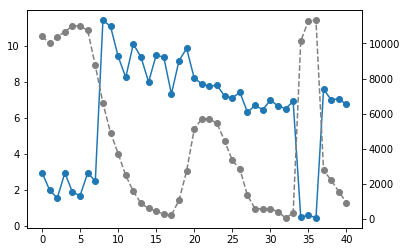

In [141]:
fig, ax = plt.subplots()
ax.plot(atom_meono2[points_within].values, marker='o');
ax2 = ax.twinx()
ax2.plot(atom_dsmms.G_ALT[points_within].data, color='grey', linestyle='--', marker='o');

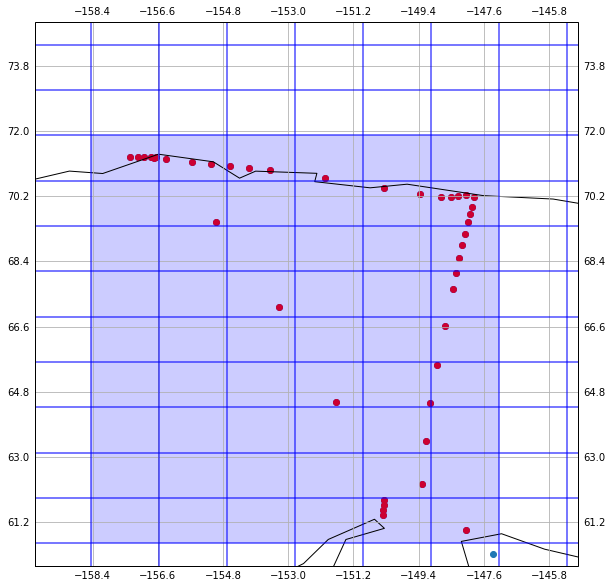

In [146]:
fig, ax = plt.subplots(figsize=(10,10), subplot_kw=dict(projection=ccrs.PlateCarree()), facecolor='w')
ax.scatter(lons_meono2_notnan, lats_meono2_notnan, transform=ccrs.PlateCarree())
ax.scatter(lons_meono2_notnan[points_within], lats_meono2_notnan[points_within], color='r', transform=ccrs.PlateCarree())

ax.add_patch(mpatches.Rectangle(xy=r1_00, width=r1_01[1]-r1_00[1], height=r1_11[0]-r1_01[0], facecolor='blue', alpha=0.2, transform=ccrs.PlateCarree()))

ax.plot(grid_lons, grid_lats, color='b', alpha=0.7, transform=ccrs.PlateCarree())
ax.plot(grid_lons.T, grid_lats.T, color='b', alpha=0.7, transform=ccrs.PlateCarree())
ax.gridlines(draw_labels=True)
ax.coastlines()
ax.set_extent([-160, -145, 60, 75], crs=ccrs.PlateCarree());
# ax.set_extent([-160, -115, -2, 75], crs=ccrs.PlateCarree()) # both Jan flights

In [ ]:
# # without shapely
# idx_within = ((lats_meono2_notnan <= 75)
#               & (lats_meono2_notnan >= 60)
#               & (lons_meono2_notnan >= 200)
#               & (lons_meono2_notnan <= 215))

In [219]:
mod_meono2 = cb_meono2.extract(iris.Constraint(longitude=lambda cell: 201.5625 <= cell <= 212.8125, latitude=lambda cell: 60.625 <= cell <= 71.875))

In [191]:
mod2_meono2 = mod_meono2.collapsed(['latitude', 'longitude'], iris.analysis.MEAN)

In [235]:
mod2_meono2.coord('altitude').points[0:43]

array([  514.8485 ,   546.31757,   590.3802 ,   647.0422 ,   716.3112 ,
         798.19666,   892.70935,   999.86206,  1119.669  ,  1252.1464 ,
        1397.3123 ,  1555.1849 ,  1725.7869 ,  1909.1399 ,  2105.2686 ,
        2314.1992 ,  2535.9604 ,  2770.5813 ,  3018.092  ,  3278.5276 ,
        3551.921  ,  3838.3088 ,  4137.73   ,  4450.223  ,  4775.829  ,
        5114.593  ,  5466.557  ,  5831.77   ,  6210.279  ,  6602.134  ,
        7007.3857 ,  7426.089  ,  7858.297  ,  8304.068  ,  8763.465  ,
        9236.536  ,  9723.361  , 10223.994  , 10738.526  , 11267.032  ,
       11809.6045 , 12366.348  , 12937.385  ], dtype=float32)

In [227]:
alt_bins

array([    0,   500,  1000,  1500,  2000,  2500,  3000,  3500,  4000,
        4500,  5000,  5500,  6000,  6500,  7000,  7500,  8000,  8500,
        9000,  9500, 10000, 10500, 11000, 11500, 12000, 12500, 13000,
       13500])

In [201]:
# Choose bins
alt_bins = np.arange(0, 14000, 500)
alt_mod_bin_inds = np.arange(0, len(alt_bins), 1)
alt_obs_bin_inds = np.digitize(atom_dsmms.G_ALT.data[points_within], alt_bins)
# Bin observational data
obs_meono2_bin_mean = atom_meono2[points_within].groupby(alt_obs_bin_inds).mean().reindex(index=alt_mod_bin_inds, fill_value=np.nan)
obs_meono2_bin_min = atom_meono2[points_within].groupby(alt_obs_bin_inds).min().reindex(index=alt_mod_bin_inds, fill_value=np.nan)
obs_meono2_bin_max = atom_meono2[points_within].groupby(alt_obs_bin_inds).max().reindex(index=alt_mod_bin_inds, fill_value=np.nan)
# Convert iris cubes with model data to pandas dataframes
_ = mod2_meono2.copy()
for coord in mod2_meono2.coords():
    if coord.standard_name in ['latitude', 'longitude', 'model_level_number', 'time', 'forecast_period', 'forecast_reference_time', 'surface_altitude']:
        _.remove_coord(coord)
_.remove_coord('level_height')
_.remove_coord('sigma')
mod2_pd_meono2 = iris.pandas.as_data_frame(_)
# Bin model data
mod_meono2_bin_mean = mod2_pd_meono2.groupby(alt_obs_bin_inds).mean().reindex(index=alt_mod_bin_inds, fill_value=np.nan).squeeze()
mod_meono2_bin_min = mod2_pd_meono2.groupby(alt_obs_bin_inds).min().reindex(index=alt_mod_bin_inds, fill_value=np.nan).squeeze()
mod_meono2_bin_max = mod2_pd_meono2.groupby(alt_obs_bin_inds).max().reindex(index=alt_mod_bin_inds, fill_value=np.nan).squeeze()

ValueError: Grouper and axis must be same length

In [200]:
mod2_pd_meono2.shape

(85, 1)

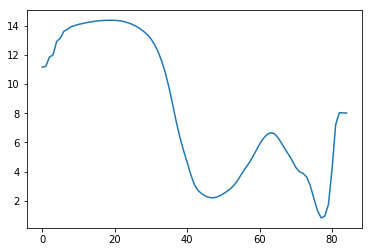

In [204]:
plt.plot(mod2_pd_meono2.squeeze());

In [114]:
# Vertical profile plotting parameters
vp_barh_kwargs = dict(height=200, align='center', alpha=1)
def plot_vp(atom, ukca, species, ppn, picname, atom_min, atom_max):
    '''Plot vertical profile along a flight track.'''
    fig, ax = plt.subplots(figsize=(7,7), facecolor='w')
    ax.plot(atom, alt_bins, color='k')
    ax.barh(alt_bins, atom_max-atom_min, left=atom_min, color='k', **vp_barh_kwargs)
#     ax.plot(ukca, alt_bins, color='r')
#     ax.barh(alt_bins, ukca_max-ukca_min, left=ukca_min, color='r', **vp_barh_kwargs)
    # common
    ax.set_title(f'{species}, {ppn}', loc='right')
#     ax.set_title(f'{atom_date_start.strftime("%-d %b %Y")}', loc='left')
    ax.set_ylabel('Altitude, km')
    ax.set_ylim(-200,13500)
    ax.set_yticks(alt_bins)
    ax.set_yticklabels(map(int,(alt_bins/1000)))
    ax.legend(['ATom', f'UKCA {ukca_run_name} montly mean'], frameon=False)
    for ytcklbl in ax.yaxis.get_ticklabels()[1::2]:
        ytcklbl.set_visible(False)
    if savefig: fig.savefig(path_to_figs / f'{ukca_run_name}_{compared_common_id}_{picname}.png', bbox_inches='tight')

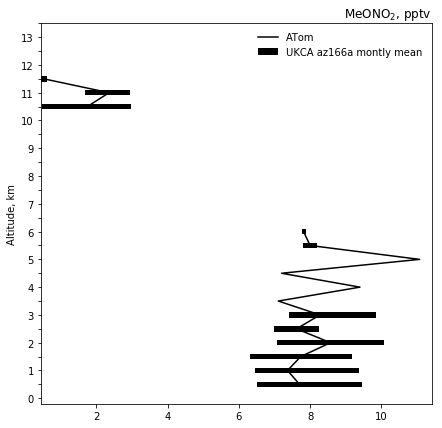

In [115]:
plot_vp(obs_meono2_bin_mean, str_meono2, 'pptv', 'vp_RONO2_C1', 
        obs_meono2_bin_min.MeONO2_WAS, obs_meono2_bin_max.MeONO2_WAS)

#### Time series of concentrations along flight track

In [ ]:
# Extract datetimes from ATom data
atom_datetime = atom_dsinf.time.values.astype('<M8[us]').astype(datetime)
atom_date_strt = atom_datetime[0]
atom_date_stop = atom_datetime[-1]
# Time series and cross section plotting parameters
if compared_common_id == '160801_160823_1608_merge':
    flght_separators = [147, 276, 427, 572, 735, 894, 1055, 1212, 1329] # manually select indices of flight start times in a merge
    slct_time_inds = np.arange(0, atom_dsinf.time.shape[0], 250) # manually choose frequency of datetimes for xticklabels
elif compared_common_id == '170126_170130_1701_merge':
    flght_separators = [141]
    slct_time_inds = np.arange(0, atom_dsinf.time.shape[0], 48)
elif compared_common_id == '170201_170221_1702_merge':
    flght_separators = [165, 324, 477, 633, 776, 928, 1077, 1236] 
    slct_time_inds = np.arange(0, atom_dsinf.time.shape[0], 250)
slct_time_lbls = [i.strftime('%H:%M\n%d-%m-%Y') for i in atom_dsinf.time.values[slct_time_inds].astype('<M8[us]').astype(datetime)]
print(slct_time_inds, atom_dsinf.time.shape)

In [ ]:
# Time series plotting parameters
def plot_ts(atom, ukca, species, ppn, picname):
    '''Plot observed and modelled species time series along a flight track (flight altitude is on the secondary y axis).'''
    fig, ax = plt.subplots(figsize=(12,4), facecolor='w')
    ax.plot(atom, color='k')
    ax.plot(ukca, color='r')
    ax2 = ax.twinx()
    ax2.plot(atom_dsmms.G_ALT, color='grey', linestyle='--', alpha=0.5)
    # common
    ax.set_title(species)
    ax.set_xlabel('Time, hours (UTC)')
    ax.set_ylabel(ppn)
    ax.set_xticks(slct_time_inds)
    ax.set_xticklabels(slct_time_lbls)
    ax.margins(x=0)
    ax.legend(['ATom', f'UKCA {ukca_run_name} montly mean'], frameon=False)
    ax2.yaxis.set_major_formatter(FuncFormatter(m2km))
    ax2.set_ylabel('Altitude, km', color='grey')
    ax2.tick_params('y', colors='grey')
    for x in flght_separators: ax.axvline(x=x, ymin=0, ymax=1500, color='grey', linestyle='--', linewidth=1)
    if savefig: fig.savefig(path_to_figs / f'{ukca_run_name}_{compared_common_id}_{picname}.png', bbox_inches='tight')

In [ ]:
plot_ts(atom_dswas_c2h6, traj_c2h6_ifobsexist*2, str_c2h6, 'pptvC', 'ts_RH_C2')

In [ ]:
plot_ts(atom_dswas_c3h8, traj_c3h8_ifobsexist*3, str_c3h8, 'pptvC', 'ts_RH_C3')

In [ ]:
plot_ts(atom_dswas['n-Butane_WAS'], traj_nc4h10_ifobsexist, str_nc4h10, 'pptv', 'ts_RH_C4n')

In [ ]:
plot_ts(atom_dswas['i-Butane_WAS'], traj_ic4h10_ifobsexist, str_ic4h10, 'pptv', 'ts_RH_C4i')

In [ ]:
plot_ts(atom_dswas['n-Pentane_WAS'], traj_nc5h12_ifobsexist, str_nc5h12, 'pptv', 'ts_RH_C5n')

In [ ]:
plot_ts(atom_dswas['i-Pentane_WAS'], traj_ic5h12_ifobsexist, str_ic5h12, 'pptv', 'ts_RH_C5i')

In [ ]:
plot_ts(atom_dswas['MeONO2_WAS'], traj_meono2_ifobsexist, str_meono2, 'pptv', 'ts_RONO2_C1')

In [ ]:
plot_ts(atom_dswas['2-BuONO2_WAS'], traj_sbuono2_ifobsexist, str_sbuono2, 'pptv', 'ts_RONO2_C4s')

In [ ]:
plot_ts(atom_dswas['2-PenONO2_WAS'], traj_n2peono2_ifobsexist, str_n2peono2, 'pptv', 'ts_RONO2_C5n2')

In [ ]:
plot_ts(atom_dswas['3-PenONO2_WAS'], traj_n3peono2_ifobsexist, str_n3peono2, 'pptv', 'ts_RONO2_C5n3')

In [ ]:
plot_ts(atom_dswas['3-Methyl-2-BuONO2_WAS'], traj_ipeono2_ifobsexist, str_ipeono2, 'pptv', 'ts_RONO2_C5i')

#### Cross section along flight track

In [ ]:
# Read precalculated UKCA 2D trajectories
crsc_c2h6 = iris.load_cube(str(path_to_prcd)+f'/{ukca_run_name}_{compared_common_id}_crsc_c2h6.nc')
crsc_c3h8 = iris.load_cube(str(path_to_prcd)+f'/{ukca_run_name}_{compared_common_id}_crsc_c3h8.nc')
crsc_nc4h10 = iris.load_cube(str(path_to_prcd)+f'/{ukca_run_name}_{compared_common_id}_crsc_nc4h10.nc')
crsc_ic4h10 = iris.load_cube(str(path_to_prcd)+f'/{ukca_run_name}_{compared_common_id}_crsc_ic4h10.nc')
crsc_nc5h12 = iris.load_cube(str(path_to_prcd)+f'/{ukca_run_name}_{compared_common_id}_crsc_nc5h12.nc')
crsc_ic5h12 = iris.load_cube(str(path_to_prcd)+f'/{ukca_run_name}_{compared_common_id}_crsc_ic5h12.nc')
crsc_meono2 = iris.load_cube(str(path_to_prcd)+f'/{ukca_run_name}_{compared_common_id}_crsc_meono2.nc')
crsc_sbuono2 = iris.load_cube(str(path_to_prcd)+f'/{ukca_run_name}_{compared_common_id}_crsc_sbuono2.nc')
crsc_n2peono2 = iris.load_cube(str(path_to_prcd)+f'/{ukca_run_name}_{compared_common_id}_crsc_n2peono2.nc')
crsc_n3peono2 = iris.load_cube(str(path_to_prcd)+f'/{ukca_run_name}_{compared_common_id}_crsc_n3peono2.nc')
crsc_ipeono2 = iris.load_cube(str(path_to_prcd)+f'/{ukca_run_name}_{compared_common_id}_crsc_ipeono2.nc')

In [ ]:
# Convert xarray dataset with observational data to pandas dataframe
atom_c2h6 = atom_dswas_c2h6.to_dataframe(name='Lumped_C2H6_C2H4_C2H2')
atom_c3h8 = atom_dswas_c3h8.to_dataframe(name='Lumped_C3H8_C3H6')
atom_nc4h10 = atom_dswas['n-Butane_WAS'].to_dataframe()
atom_ic4h10 = atom_dswas['i-Butane_WAS'].to_dataframe()
atom_nc5h12 = atom_dswas['n-Pentane_WAS'].to_dataframe()
atom_ic5h12 = atom_dswas['i-Pentane_WAS'].to_dataframe()
atom_meono2 = atom_dswas['MeONO2_WAS'].to_dataframe()
atom_sbuono2 = atom_dswas['2-BuONO2_WAS'].to_dataframe()
atom_n2peono2 = atom_dswas['2-PenONO2_WAS'].to_dataframe()
atom_n3peono2 = atom_dswas['3-PenONO2_WAS'].to_dataframe()
atom_ipeono2 = atom_dswas['3-Methyl-2-BuONO2_WAS'].to_dataframe()

In [ ]:
# Find max between maxima and max between minima in ATom and model cross section data for plotting a cross section with two colormaps
cs_c2h6_max = max(np.nanmax(atom_c2h6.values), np.nanmax(crsc_c2h6.data*2))
cs_c3h8_max = max(np.nanmax(atom_c3h8.values), np.nanmax(crsc_c3h8.data*3))
cs_nc4h10_max = max(np.nanmax(atom_nc4h10.values), np.nanmax(crsc_nc4h10.data))
cs_ic4h10_max = max(np.nanmax(atom_ic4h10.values), np.nanmax(crsc_ic4h10.data))
cs_nc5h12_max = max(np.nanmax(atom_nc5h12.values), np.nanmax(crsc_nc5h12.data))
cs_ic5h12_max = max(np.nanmax(atom_ic5h12.values), np.nanmax(crsc_ic5h12.data))
cs_meono2_max = max(np.nanmax(atom_meono2.values), np.nanmax(crsc_meono2.data))
cs_sbuono2_max = max(np.nanmax(atom_sbuono2.values), np.nanmax(crsc_sbuono2.data))
cs_n2peono2_max = max(np.nanmax(atom_n2peono2.values), np.nanmax(crsc_n2peono2.data))
cs_n3peono2_max = max(np.nanmax(atom_n3peono2.values), np.nanmax(crsc_n3peono2.data))
cs_ipeono2_max = max(np.nanmax(atom_ipeono2.values), np.nanmax(crsc_ipeono2.data))

cs_c2h6_min = min(np.nanmax(atom_c2h6.values), np.nanmax(crsc_c2h6.data*2))
cs_c3h8_min = min(np.nanmax(atom_c3h8.values), np.nanmax(crsc_c3h8.data*3))
cs_nc4h10_min = min(np.nanmax(atom_nc4h10.values), np.nanmax(crsc_nc4h10.data))
cs_ic4h10_min = min(np.nanmax(atom_ic4h10.values), np.nanmax(crsc_ic4h10.data))
cs_nc5h12_min = min(np.nanmax(atom_nc5h12.values), np.nanmax(crsc_nc5h12.data))
cs_ic5h12_min = min(np.nanmax(atom_ic5h12.values), np.nanmax(crsc_ic5h12.data))
cs_meono2_min = min(np.nanmax(atom_meono2.values), np.nanmax(crsc_meono2.data))
cs_sbuono2_min = min(np.nanmax(atom_sbuono2.values), np.nanmax(crsc_sbuono2.data))
cs_n2peono2_min = min(np.nanmax(atom_n2peono2.values), np.nanmax(crsc_n2peono2.data))
cs_n3peono2_min = min(np.nanmax(atom_n3peono2.values), np.nanmax(crsc_n3peono2.data))
cs_ipeono2_min = min(np.nanmax(atom_ipeono2.values), np.nanmax(crsc_ipeono2.data))

In [ ]:
# Cross section plotting parameters
mrgd_time_inds = np.arange(0,atom_dsinf.time.values.shape[0],1) # merged time indices
# Merge two colormaps: color concentrations present in obs and model using one colormap and obs higher than model using another colormap
class MidpointNormalize(colors.Normalize):
    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        self.midpoint = midpoint
        colors.Normalize.__init__(self, vmin, vmax, clip)
    def __call__(self, value, clip=None):
        x, y = [self.vmin, self.midpoint, self.vmax], [0, 0.5, 1]
        return np.ma.masked_array(np.interp(value, x, y))
colors_low = plt.cm.Blues(np.linspace(0,1,128))
colors_high = plt.cm.autumn_r(np.linspace(0,1,128))
colors_stack = np.vstack((colors_low, colors_high))
mrgd_cmap = colors.LinearSegmentedColormap.from_list('merged_cmap', colors_stack)
cs_pc_kwargs = dict(cmap=mrgd_cmap, vmin=0) # model data pcolormesh options
cs_sc_kwargs = dict(cmap=mrgd_cmap, vmin=0, edgecolors='k', linewidth=0.2) # obs data scatter options
def plot_cs(atom, ukca, species, ppn, picname, cs_min, cs_max):
    '''Plot a cross section along a flight track, modelled data as background and observed data as dots.'''
    fig, ax = plt.subplots(figsize=(14,5), facecolor='w')
    p0 = ax.pcolormesh(mrgd_time_inds, crsc_c2h6.coord('altitude').points, ukca, norm=MidpointNormalize(midpoint=cs_min), vmax=cs_max, **cs_pc_kwargs)
    ax.scatter(mrgd_time_inds, atom_dsmms.G_ALT, c=atom.squeeze(), norm=MidpointNormalize(midpoint=cs_min), vmax=cs_max, **cs_sc_kwargs)
    fig.colorbar(p0, label=ppn)
    # common
    ax.set_title(species, loc='center')
    ax.set_title(f'ATom vs UKCA {ukca_run_name} montly mean', loc='right')
    ax.set_xlabel('Time, hours (UTC)')
    ax.set_ylabel('Altitude, km')
    ax.set_ylim(0,13500)
    ax.set_xticks(slct_time_inds)
    ax.set_xticklabels(slct_time_lbls)
    ax.yaxis.set_major_formatter(FuncFormatter(m2km))
    ax.margins(x=0)
    for x in flght_separators: ax.axvline(x=x, ymin=0, ymax=13500, color='grey', linestyle='--', linewidth=1)
    if savefig: fig.savefig(path_to_figs / f'{ukca_run_name}_{compared_common_id}_{picname}.png', bbox_inches='tight')

In [ ]:
plot_cs(atom_c2h6, crsc_c2h6.data*2, str_c2h6, 'pptvC', 'cs_RH_C2', cs_c2h6_min, cs_c2h6_max)

In [ ]:
plot_cs(atom_c3h8, crsc_c3h8.data*3, str_c3h8, 'pptvC', 'cs_RH_C3', cs_c3h8_min, cs_c3h8_max)

In [ ]:
plot_cs(atom_nc4h10, crsc_nc4h10.data, str_nc4h10, 'pptv', 'cs_RH_C4n', cs_nc4h10_min, cs_nc4h10_max)

In [ ]:
plot_cs(atom_ic4h10, crsc_ic4h10.data, str_ic4h10, 'pptv', 'cs_RH_C4i', cs_ic4h10_min, cs_ic4h10_max)

In [ ]:
plot_cs(atom_nc5h12, crsc_nc5h12.data, str_nc5h12, 'pptv', 'cs_RH_C5n', cs_nc5h12_min, cs_nc5h12_max)

In [ ]:
plot_cs(atom_ic5h12, crsc_ic5h12.data, str_ic5h12, 'pptv', 'cs_RH_C5i', cs_ic5h12_min, cs_ic5h12_max)

In [ ]:
plot_cs(atom_meono2, crsc_meono2.data, str_meono2, 'pptv', 'cs_RONO2_C1', cs_meono2_min, cs_meono2_max)

In [ ]:
plot_cs(atom_sbuono2, crsc_sbuono2.data, str_sbuono2, 'pptv', 'cs_RONO2_C4s', cs_sbuono2_min, cs_sbuono2_max)

In [ ]:
plot_cs(atom_n2peono2, crsc_n2peono2.data, str_n2peono2, 'pptv', 'cs_RONO2_C5n2', cs_n2peono2_min, cs_n2peono2_max)

In [ ]:
plot_cs(atom_n3peono2, crsc_n3peono2.data, str_n3peono2, 'pptv', 'cs_RONO2_C5n3', cs_n3peono2_min, cs_n3peono2_max)

In [ ]:
plot_cs(atom_ipeono2, crsc_ipeono2.data, str_ipeono2, 'pptv', 'cs_RONO2_C5i', cs_ipeono2_min, cs_ipeono2_max)

#### Scatter plot data along flight track

In [ ]:
# Find max concentration between observational and model trajectory data
sct_max_c2h6 = max(np.nanmax(atom_c2h6.values), np.nanmax(traj_c2h6.data*2))
sct_max_c3h8 = max(np.nanmax(atom_c3h8.values), np.nanmax(traj_c3h8.data*3))
sct_max_nc4h10 = max(np.nanmax(atom_nc4h10.values), np.nanmax(traj_nc4h10.data))
sct_max_ic4h10 = max(np.nanmax(atom_ic4h10.values), np.nanmax(traj_ic4h10.data))
sct_max_nc5h12 = max(np.nanmax(atom_nc5h12.values), np.nanmax(traj_nc5h12.data))
sct_max_ic5h12 = max(np.nanmax(atom_ic5h12.values), np.nanmax(traj_ic5h12.data))
sct_max_meono2 = max(np.nanmax(atom_meono2.values), np.nanmax(traj_meono2.data))
sct_max_sbuono2 = max(np.nanmax(atom_sbuono2.values), np.nanmax(traj_sbuono2.data))
sct_max_n2peono2 = max(np.nanmax(atom_n2peono2.values), np.nanmax(traj_n2peono2.data))
sct_max_n3peono2 = max(np.nanmax(atom_n3peono2.values), np.nanmax(traj_n3peono2.data))
sct_max_ipeono2 = max(np.nanmax(atom_ipeono2.values), np.nanmax(traj_ipeono2.data))

In [ ]:
def plot_one2one(atom, ukca, species, ppn, picname, sct_max):
    '''Plot all flight track data as a scatter plot.'''
    fig, ax = plt.subplots(figsize=(6,5), facecolor='w')
    p0 = ax.scatter(atom, ukca, c=atom_dsmms.G_ALT)
    ax.plot([0, sct_max], [0, sct_max], color='k', linestyle='--') # 'one-to-one' line
    ax.set_title(f'{species}, {ppn}', loc='right')
    ax.set_title(f'{atom_date_strt.strftime("%-d")}-{atom_date_stop.strftime("%-d %b %Y")}', loc='left')
    ax.set_xlabel('ATom')
    ax.set_ylabel(f'UKCA {ukca_run_name} montly mean')
    ax.set_xlim(0, sct_max)
    ax.set_ylim(0, sct_max)
    fig.colorbar(p0, label='Altitude, km', format=FuncFormatter(m2km))
    if savefig: fig.savefig(path_to_figs / f'{ukca_run_name}_{compared_common_id}_{picname}.png', bbox_inches='tight')

In [ ]:
plot_one2one(atom_c2h6, traj_c2h6.data*2, str_c2h6, 'pptvC', '1to1_RH_C2', sct_max_c2h6)

In [ ]:
plot_one2one(atom_c3h8, traj_c3h8.data*3, str_c3h8, 'pptvC', '1to1_RH_C3', sct_max_c3h8)

In [ ]:
plot_one2one(atom_nc4h10, traj_nc4h10.data, str_nc4h10, 'pptv', '1to1_RH_C4n', sct_max_nc4h10)

In [ ]:
plot_one2one(atom_ic4h10, traj_ic4h10.data, str_ic4h10, 'pptv', '1to1_RH_C4i', sct_max_ic4h10)

In [ ]:
plot_one2one(atom_nc5h12, traj_nc5h12.data, str_nc5h12, 'pptv', '1to1_RH_C5n', sct_max_nc5h12)

In [ ]:
plot_one2one(atom_ic5h12, traj_ic5h12.data, str_ic5h12, 'pptv', '1to1_RH_C5i', sct_max_ic5h12)

In [ ]:
plot_one2one(atom_meono2, traj_meono2.data, str_meono2, 'pptv', '1to1_RONO2_C1', sct_max_meono2)

In [ ]:
plot_one2one(atom_sbuono2, traj_sbuono2.data, str_sbuono2, 'pptv', '1to1_RONO2_C4s', sct_max_sbuono2)

In [ ]:
plot_one2one(atom_n2peono2, traj_n2peono2.data, str_n2peono2, 'pptv', '1to1_RONO2_C5n2', sct_max_n2peono2)

In [ ]:
plot_one2one(atom_n3peono2, traj_n3peono2.data, str_n3peono2, 'pptv', '1to1_RONO2_C5n3', sct_max_n3peono2)

In [ ]:
plot_one2one(atom_ipeono2, traj_ipeono2.data, str_ipeono2, 'pptv', '1to1_RONO2_C5i', sct_max_ipeono2)